In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/purzelrakete/src/github.com/feldberlin/wavenet


In [2]:
import copy
import os

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt

import librosa.display
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

# Train on 440 hz Sines with random phases

A very simple dataset, should be able to crush this. Sines all at 440 hz, unit amplitude, random phases. Some ways of reducing the size of the problems:

- 4 cycles of sin should do, no need for a full second of audio. 160 samples
- Mu compress to 7 bits
- Fast generate only 160 samples
- Mono

We will try to train in around 10 minutes. 

In [3]:
dry = True 
if dry: os.environ['WANDB_MODE'] = 'disabled'

In [4]:
p_small = model.HParams(
    mixed_precision=True,
    embed_inputs=True,
    n_audio_chans=1, 
    n_classes=2**7, 
    compress=False, 
    sample_length=160, 
    dilation_stacks=1,
    n_layers=7,
    sample_from_gpu=True,
    seed=32455,
    n_chans=32,
    n_chans_embed=256,
    n_chans_skip=256,
    n_chans_res=32,
    n_chans_end=64,
)

tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015
)

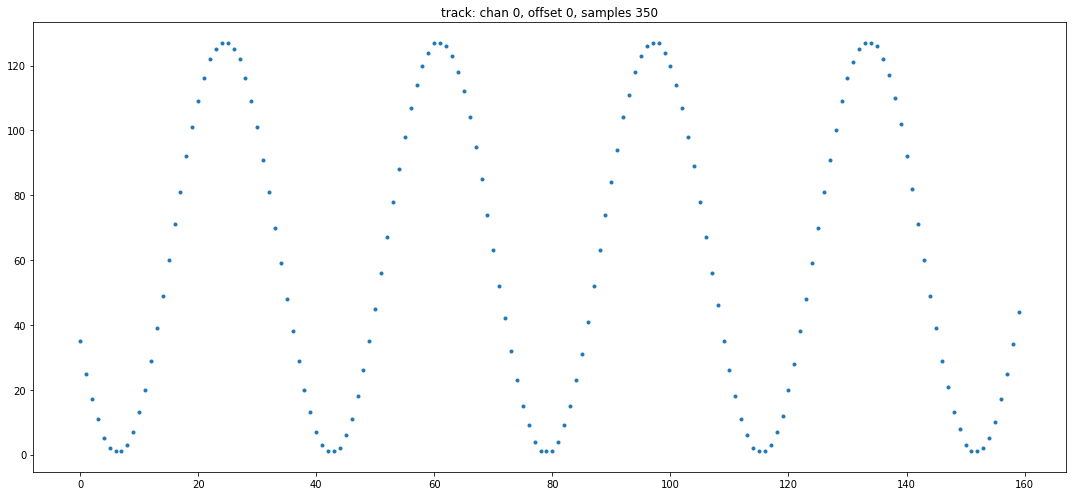

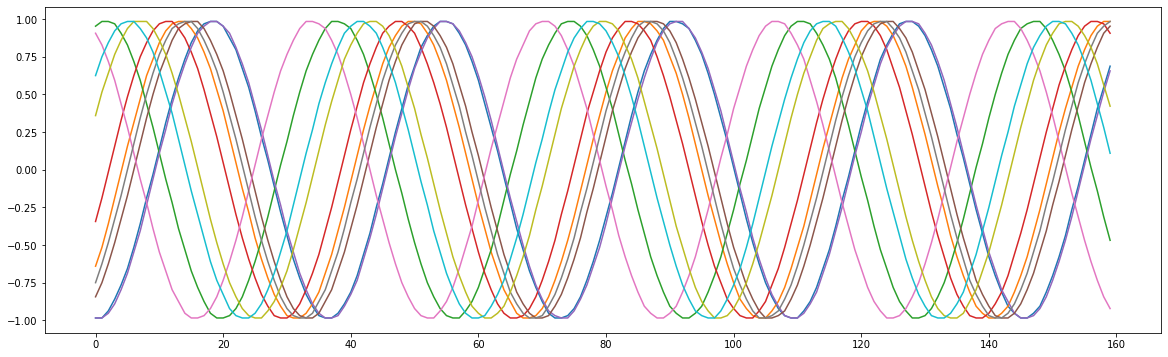

In [5]:
utils.seed(p_small)
ds = datasets.Sines(640, p_small, hz=440, amp=1.0)
viz.plot_audio_dataset(ds, p_small)

In [6]:
utils.seed(p_small)
m = model.Wavenet(p_small)
debug.summarize(m)
t = train.Trainer(m, ds, None, tp, None)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       embed.weight      |   32768    |
|      shifted.weight     |   16384    |
|       shifted.bias      |     32     |
|   layers.0.conv.weight  |    4096    |
|    layers.0.conv.bias   |     64     |
|  layers.0.res1x1.weight |    1024    |
|   layers.0.res1x1.bias  |     32     |
| layers.0.skip1x1.weight |    8192    |
|  layers.0.skip1x1.bias  |    256     |
|   layers.1.conv.weight  |    4096    |
|    layers.1.conv.bias   |     64     |
|  layers.1.res1x1.weight |    1024    |
|   layers.1.res1x1.bias  |     32     |
| layers.1.skip1x1.weight |    8192    |
|  layers.1.skip1x1.bias  |    256     |
|   layers.2.conv.weight  |    4096    |
|    layers.2.conv.bias   |     64     |
|  layers.2.res1x1.weight |    1024    |
|   layers.2.res1x1.bias  |     32     |
| layers.2.skip1x1.weight |    8192    |
|  layers.2.skip1x1.bias  |    256     |
|   layers.3.con

  0%|          | 0/40 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:39 loss 0.06952 lr 5.320725e-07: 100%|██████████| 40/40 [00:01<00:00, 31.46it/s]


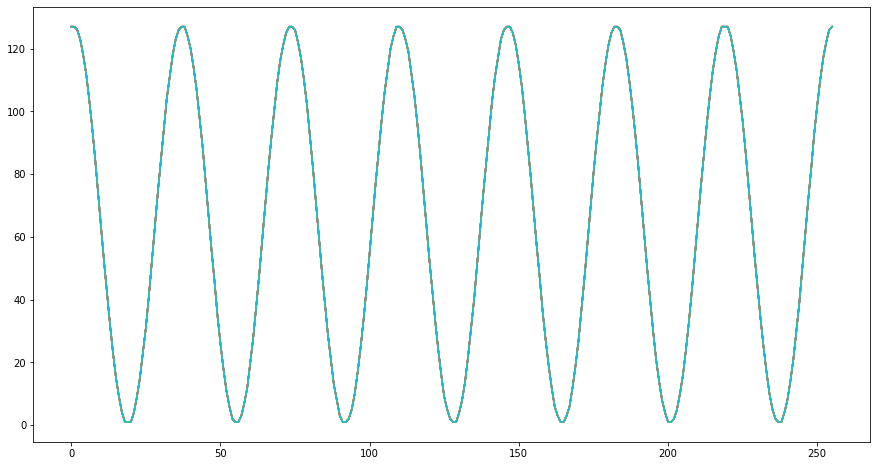

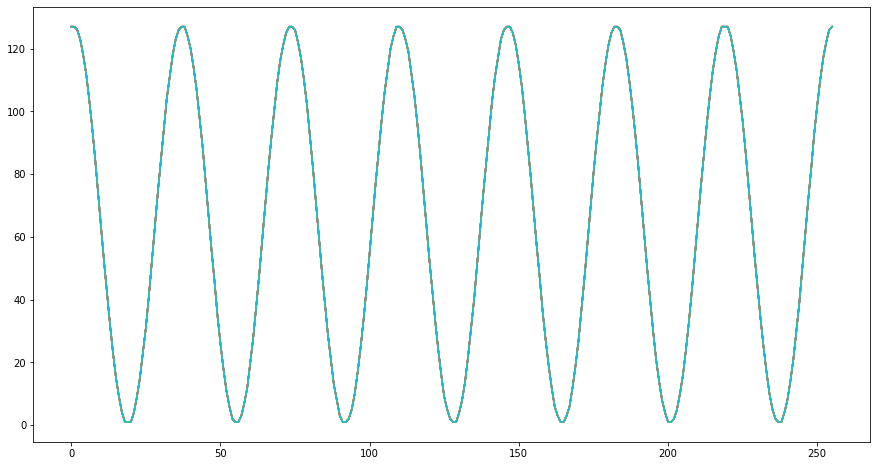

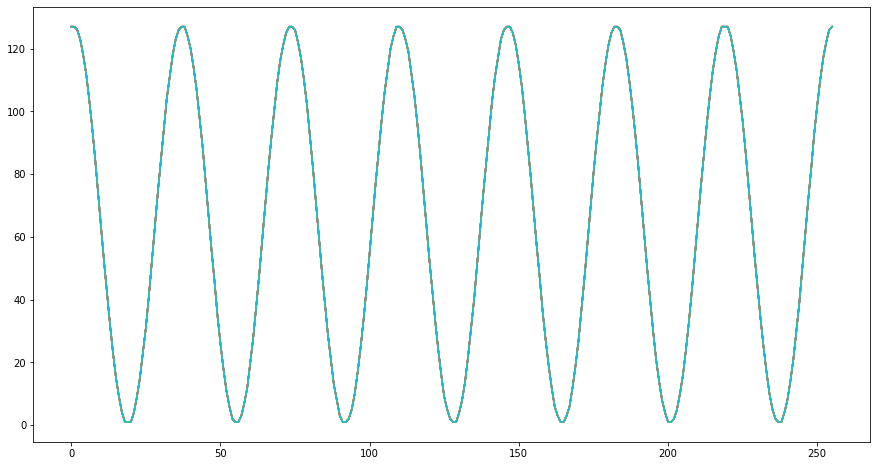

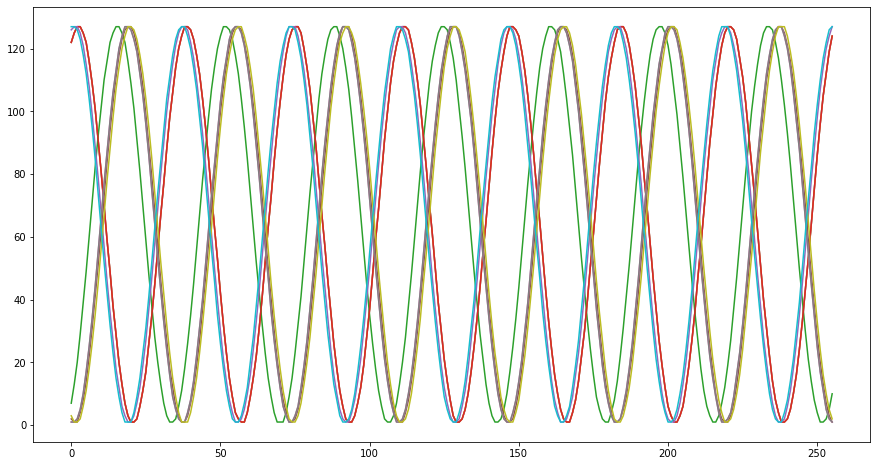

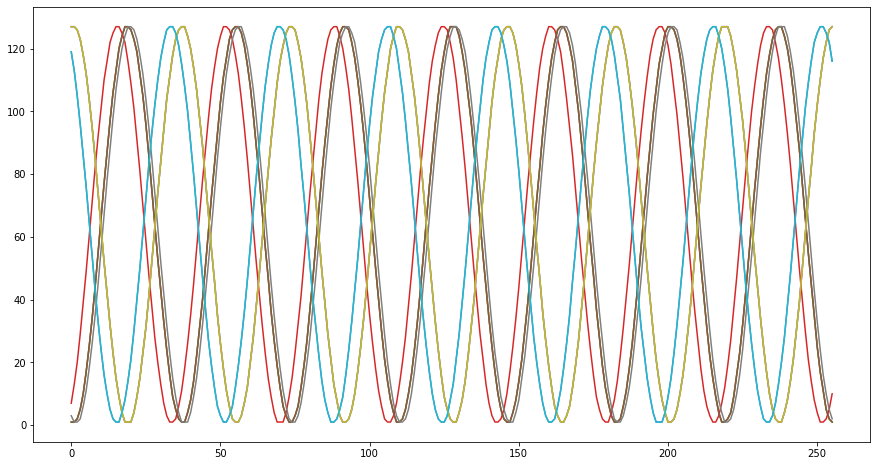

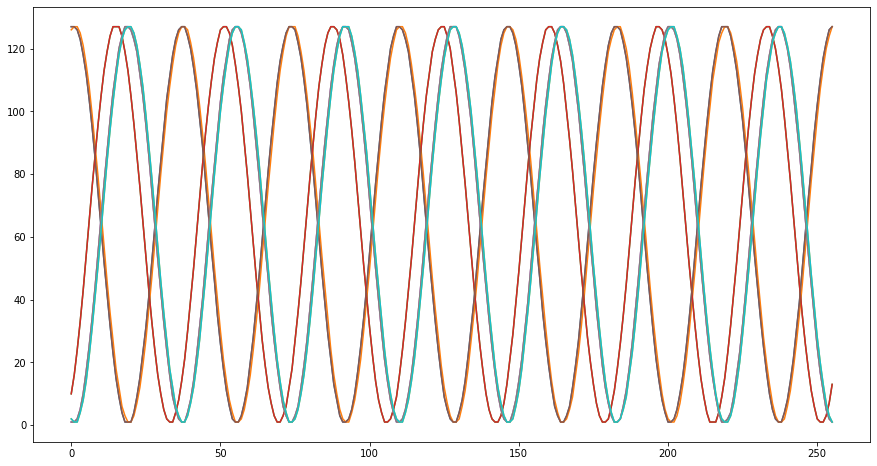

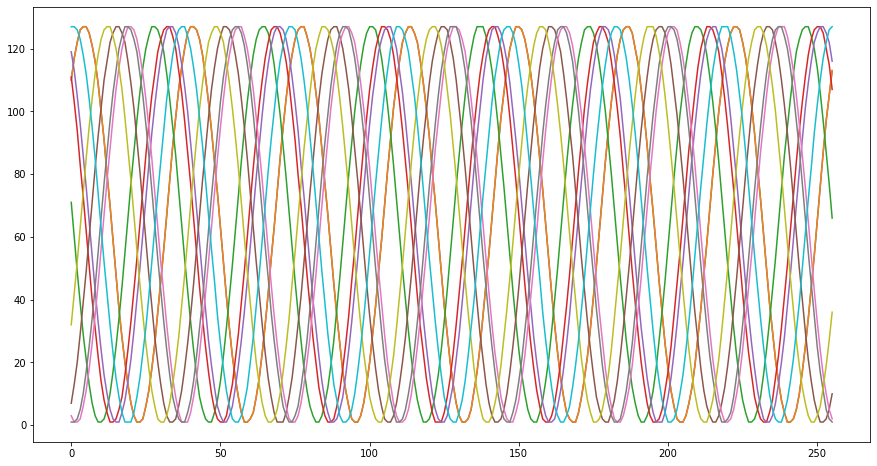

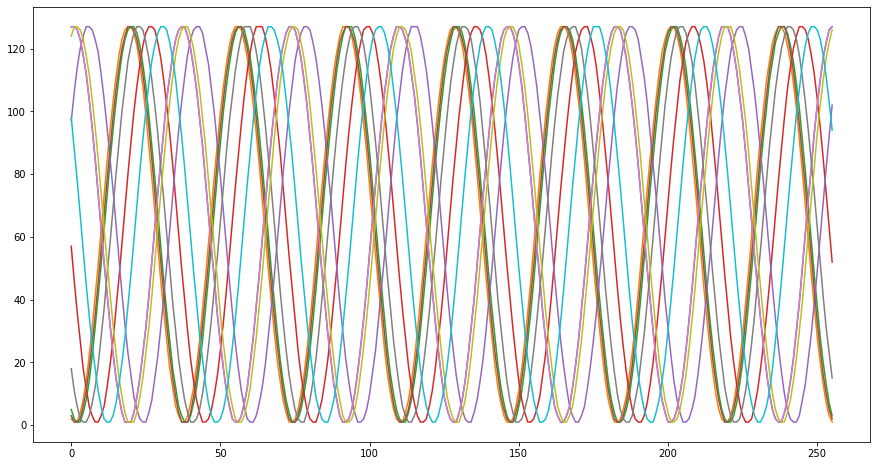

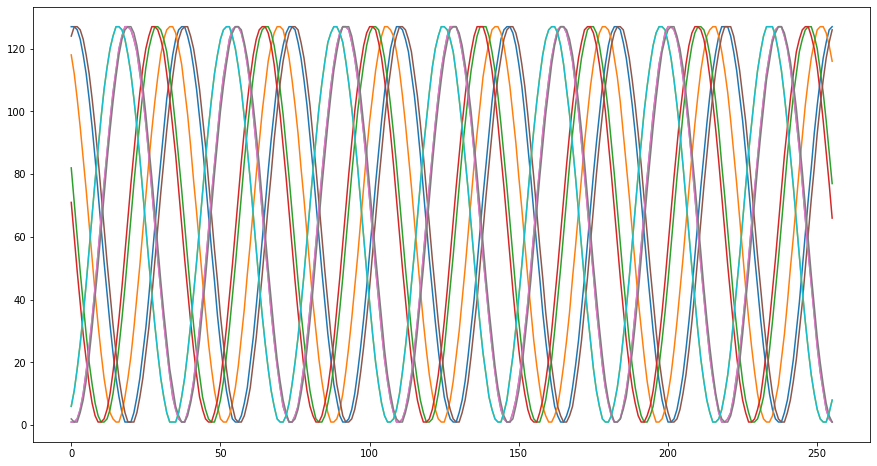

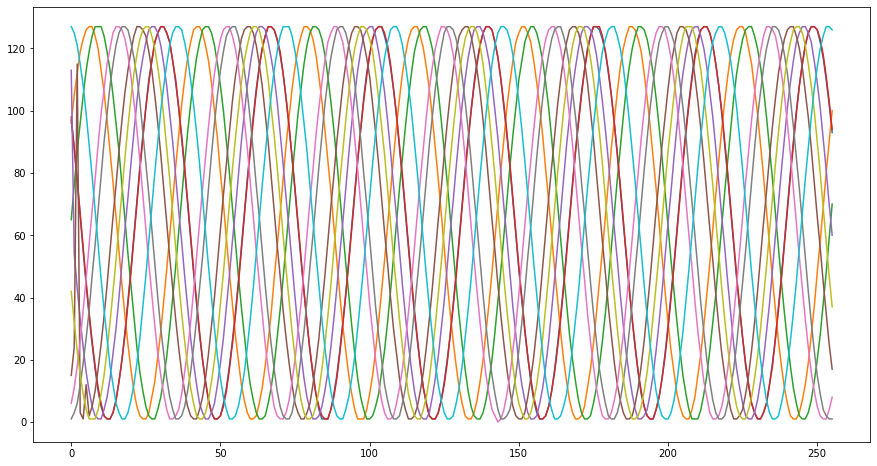

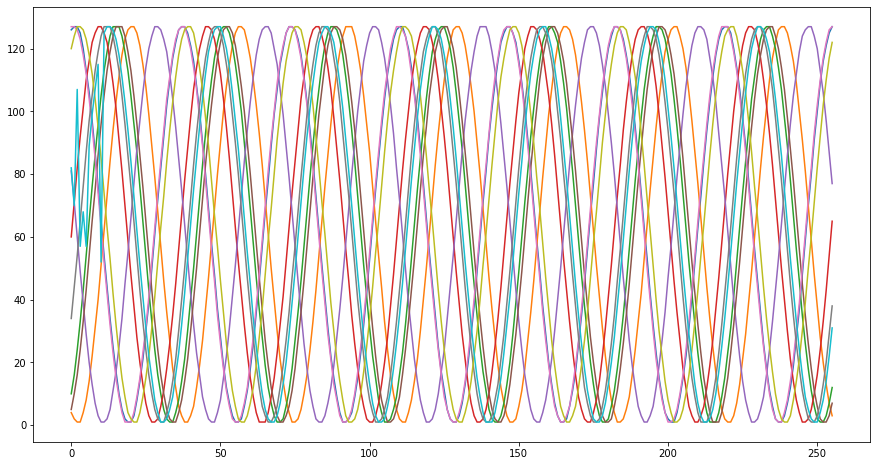

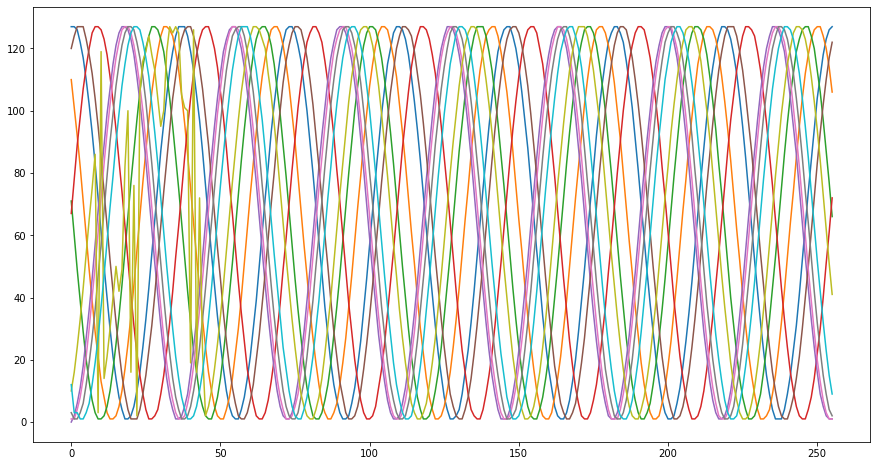

In [7]:
utils.seed(p_small)
t.train()
viz.plot_model_samples(m, ds.transforms, sample.simple, p_small)

# Train on random Sinusoids

Harder.

In [8]:
p_moderate = copy.copy(p_small)
p_moderate.n_layers = 8
p_moderate.n_chans_skip = 512
p_moderate.__dict__

{'mixed_precision': True,
 'embed_inputs': True,
 'n_audio_chans': 1,
 'n_classes': 128,
 'compress': False,
 'sample_length': 160,
 'dilation_stacks': 1,
 'n_layers': 8,
 'sample_from_gpu': True,
 'seed': 32455,
 'n_chans': 32,
 'n_chans_embed': 256,
 'n_chans_skip': 512,
 'n_chans_res': 32,
 'n_chans_end': 64}

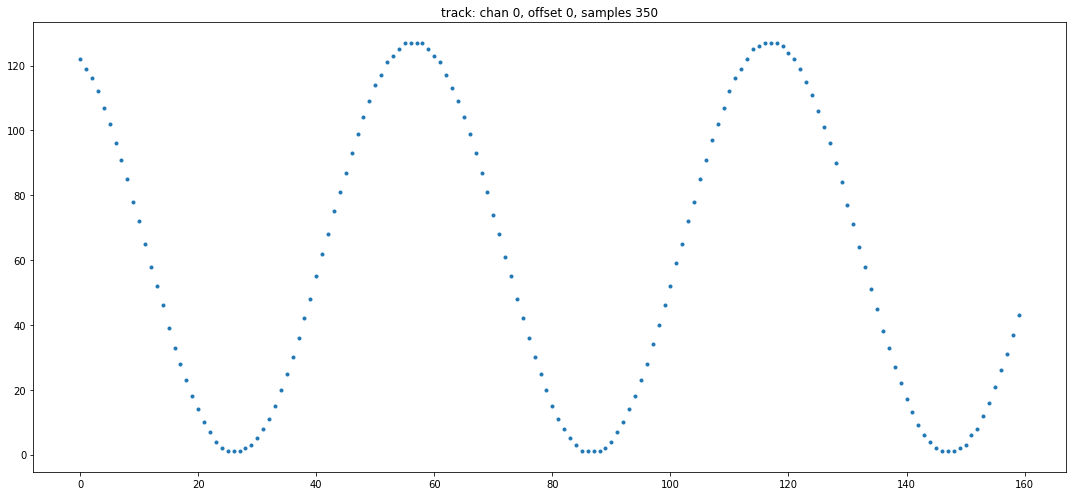

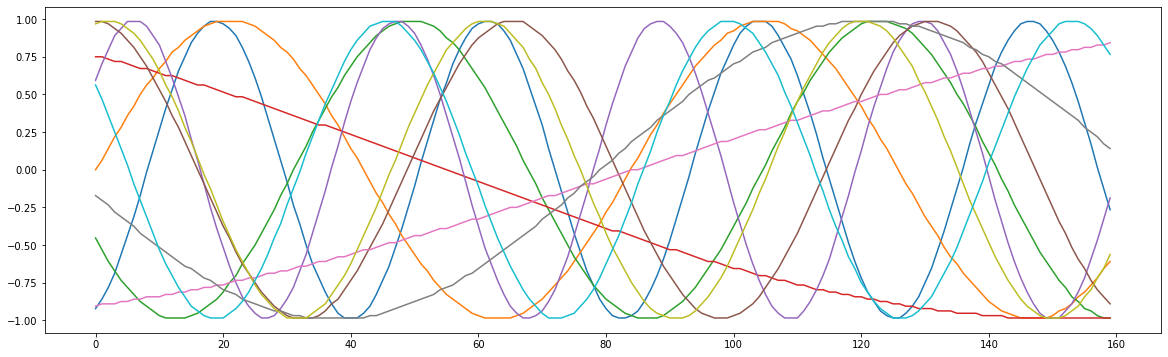

In [9]:
utils.seed(p_moderate)
ds = datasets.Sines(6400, p_moderate, amp=1.0, minhz=20, maxhz=400)
viz.plot_audio_dataset(ds, p_moderate)

In [10]:
tp = train.HParams(
    max_epochs=50, 
    batch_size=128, 
    num_workers=1, 
    learning_rate=0.05
)

m = model.Wavenet(p_moderate)
debug.summarize(m)
t = train.Trainer(m, ds, None, tp, None)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       embed.weight      |   32768    |
|      shifted.weight     |   16384    |
|       shifted.bias      |     32     |
|   layers.0.conv.weight  |    4096    |
|    layers.0.conv.bias   |     64     |
|  layers.0.res1x1.weight |    1024    |
|   layers.0.res1x1.bias  |     32     |
| layers.0.skip1x1.weight |   16384    |
|  layers.0.skip1x1.bias  |    512     |
|   layers.1.conv.weight  |    4096    |
|    layers.1.conv.bias   |     64     |
|  layers.1.res1x1.weight |    1024    |
|   layers.1.res1x1.bias  |     32     |
| layers.1.skip1x1.weight |   16384    |
|  layers.1.skip1x1.bias  |    512     |
|   layers.2.conv.weight  |    4096    |
|    layers.2.conv.bias   |     64     |
|  layers.2.res1x1.weight |    1024    |
|   layers.2.res1x1.bias  |     32     |
| layers.2.skip1x1.weight |   16384    |
|  layers.2.skip1x1.bias  |    512     |
|   layers.3.con

  0%|          | 0/50 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
50:49 loss 0.27672 lr 2.402839e-07: 100%|██████████| 50/50 [00:01<00:00, 26.08it/s]


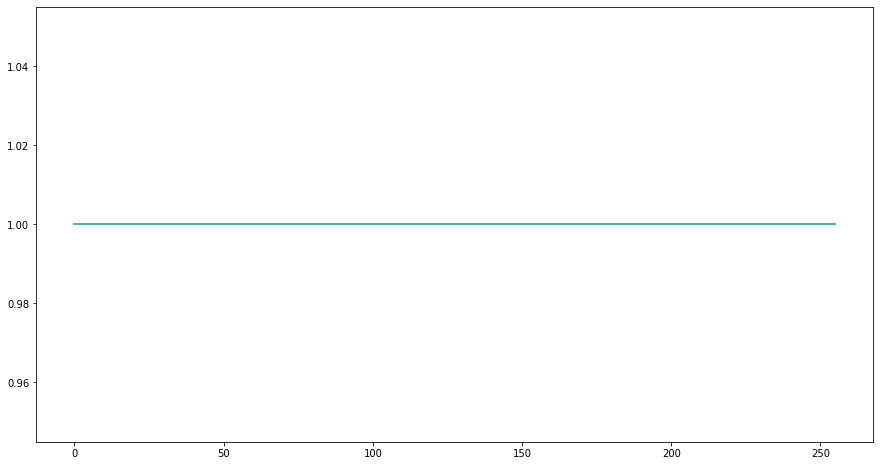

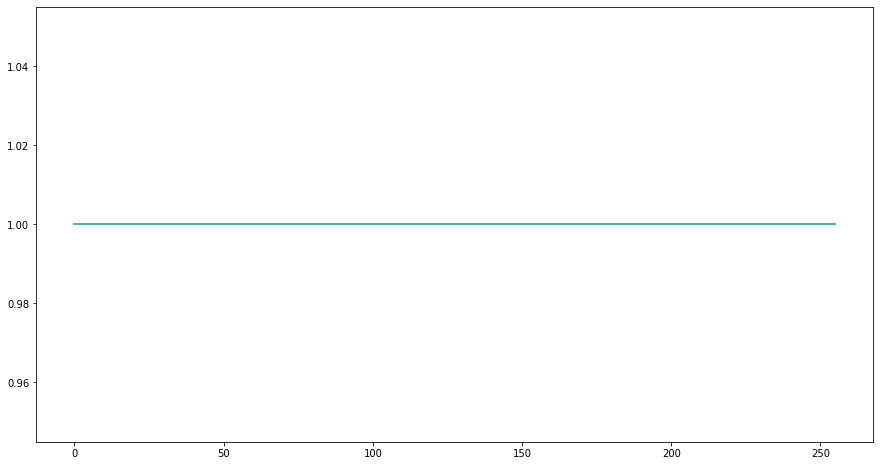

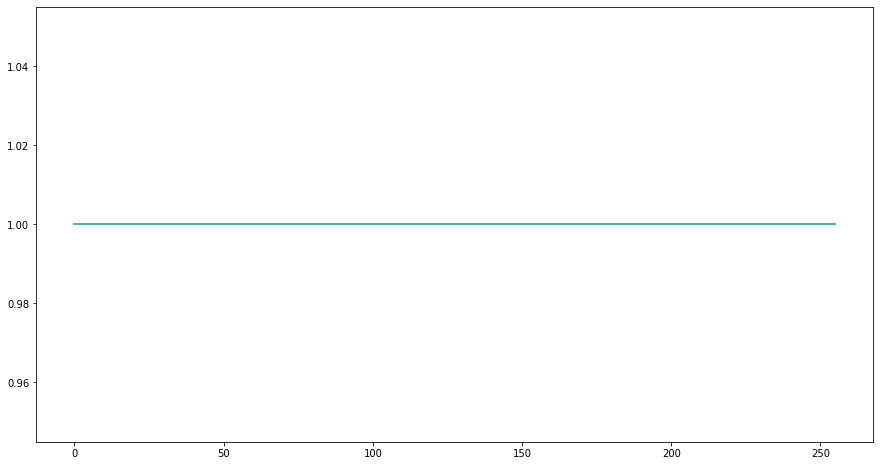

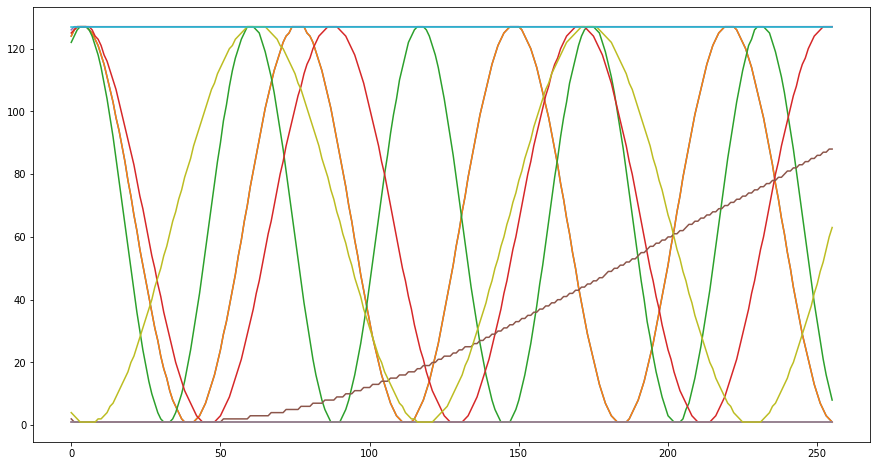

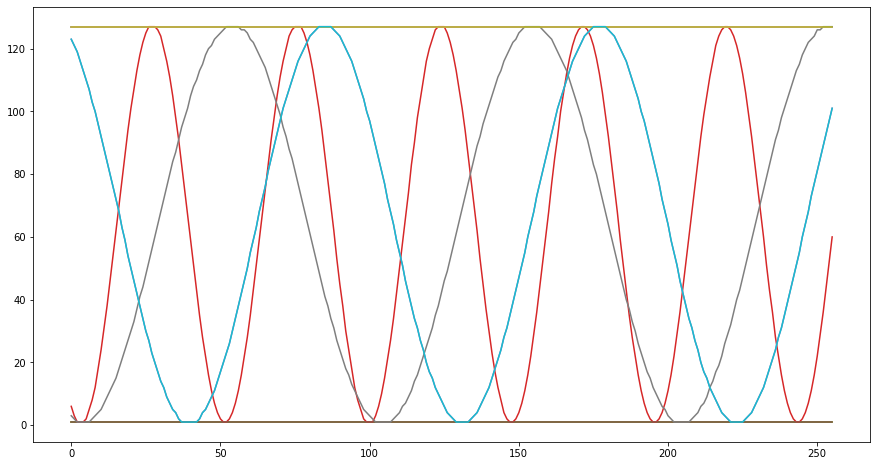

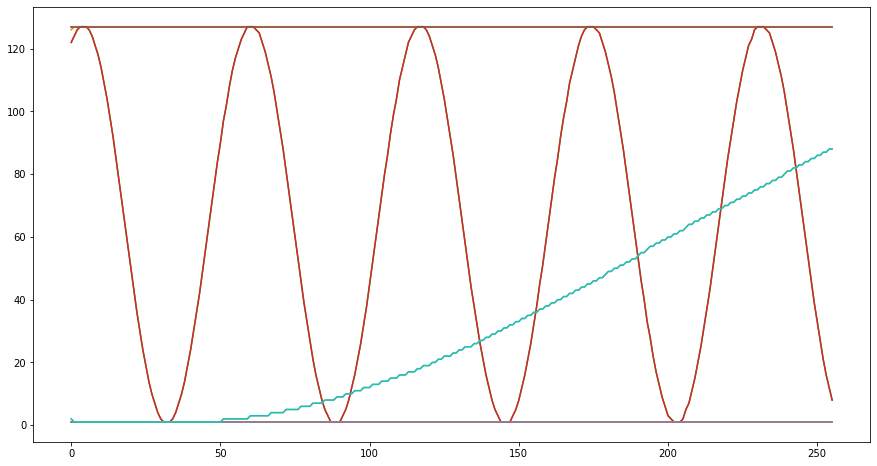

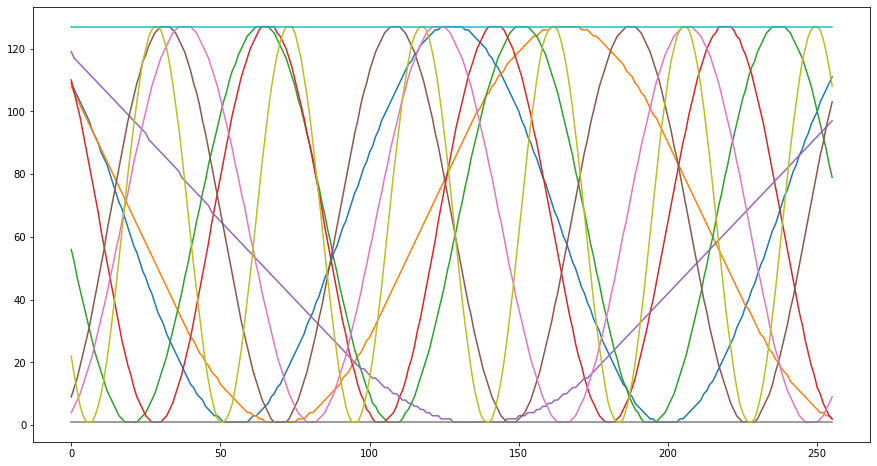

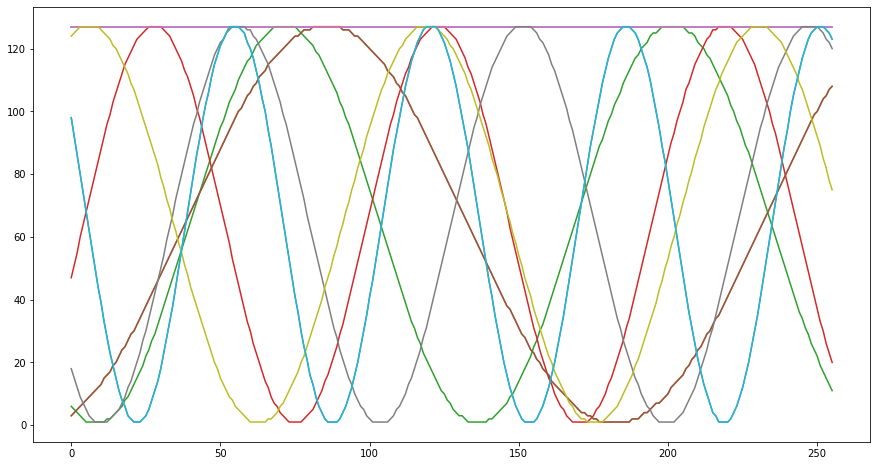

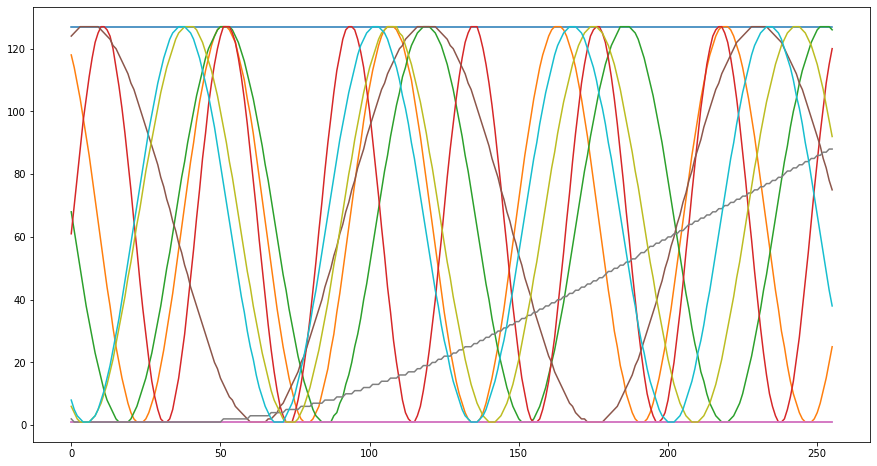

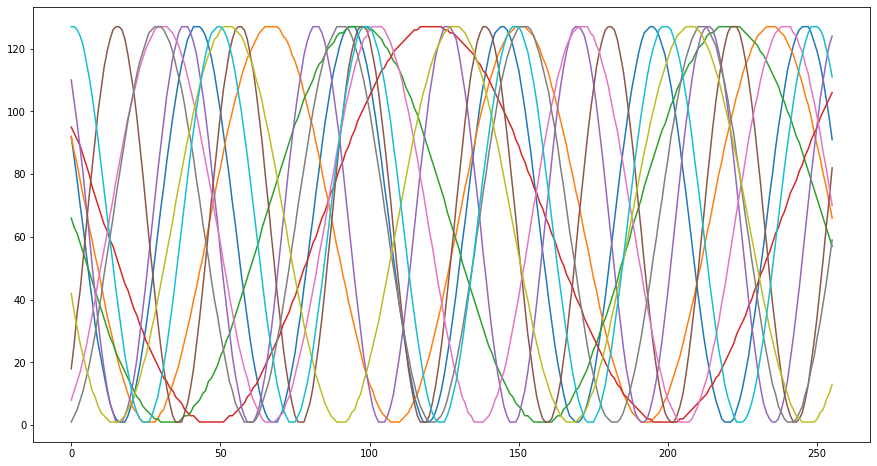

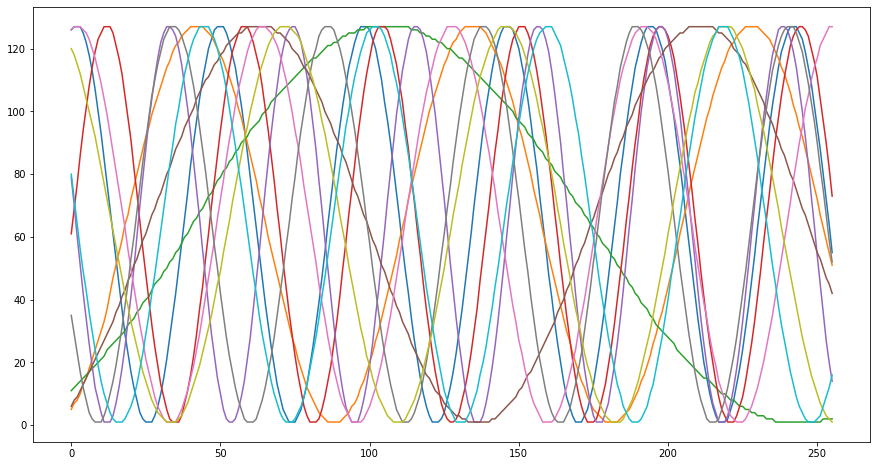

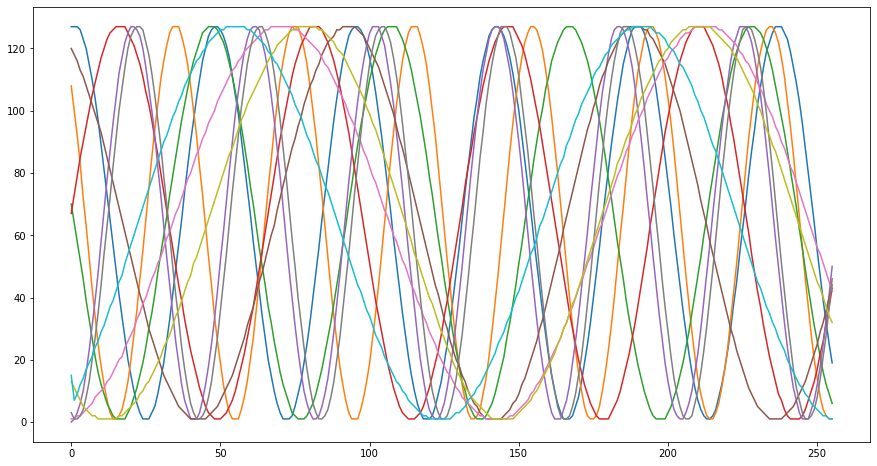

In [11]:
utils.seed(p_moderate)
t.train()
viz.plot_model_samples(m, ds.transforms, sample.simple, p_moderate)

## 🚨 Observations and Questions

- This seems to need much longer to converge. Using 2x epochs
- Using 2x params
- Why do we need to up the model and training so much? It is a harder problem, but surely not that much harder?
- The problem seems to come up with low frequency sinusoids

# Train on 20 hz Sines

Here's a bit of a puzzle. Given the same resources as training on 440 hz sines with random phases, training on 20 hz sines performs much worse:

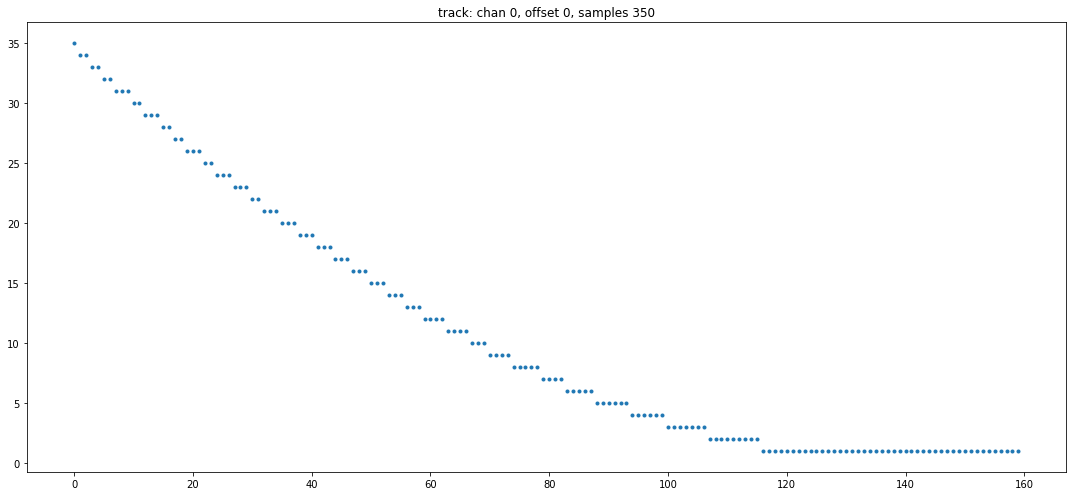

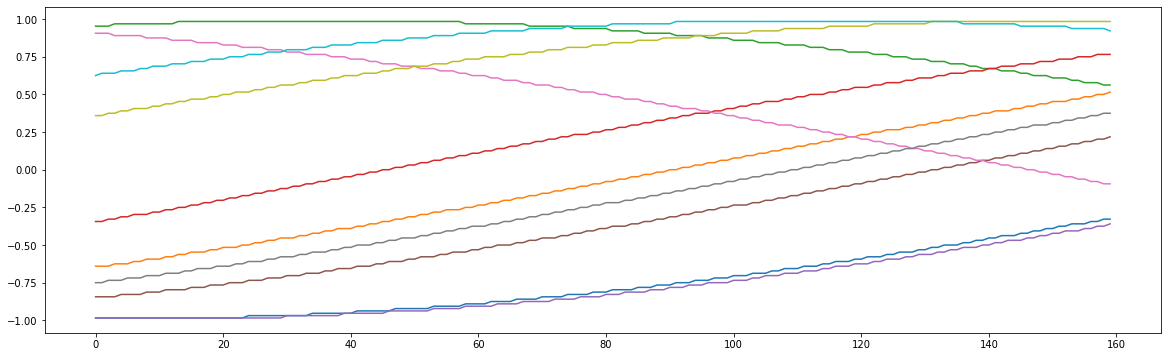

In [12]:
utils.seed(p_small)
ds = datasets.Sines(640, p_small, hz=20, amp=1.0)
viz.plot_audio_dataset(ds, p_small)

In [13]:
tp = train.HParams(
    max_epochs=10, 
    batch_size=16, 
    num_workers=1, 
    learning_rate=0.015
)

m = model.Wavenet(p_small)
debug.summarize(m)
t = train.Trainer(m, ds, None, tp, None)

+-------------------------+------------+
|         Modules         | Parameters |
+-------------------------+------------+
|       embed.weight      |   32768    |
|      shifted.weight     |   16384    |
|       shifted.bias      |     32     |
|   layers.0.conv.weight  |    4096    |
|    layers.0.conv.bias   |     64     |
|  layers.0.res1x1.weight |    1024    |
|   layers.0.res1x1.bias  |     32     |
| layers.0.skip1x1.weight |    8192    |
|  layers.0.skip1x1.bias  |    256     |
|   layers.1.conv.weight  |    4096    |
|    layers.1.conv.bias   |     64     |
|  layers.1.res1x1.weight |    1024    |
|   layers.1.res1x1.bias  |     32     |
| layers.1.skip1x1.weight |    8192    |
|  layers.1.skip1x1.bias  |    256     |
|   layers.2.conv.weight  |    4096    |
|    layers.2.conv.bias   |     64     |
|  layers.2.res1x1.weight |    1024    |
|   layers.2.res1x1.bias  |     32     |
| layers.2.skip1x1.weight |    8192    |
|  layers.2.skip1x1.bias  |    256     |
|   layers.3.con

  0%|          | 0/40 [00:00<?, ?it/s]/home/purzelrakete/src/github.com/feldberlin/wavenet/.venv/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:65: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
10:39 loss 0.06899 lr 5.320725e-07: 100%|██████████| 40/40 [00:01<00:00, 32.47it/s]


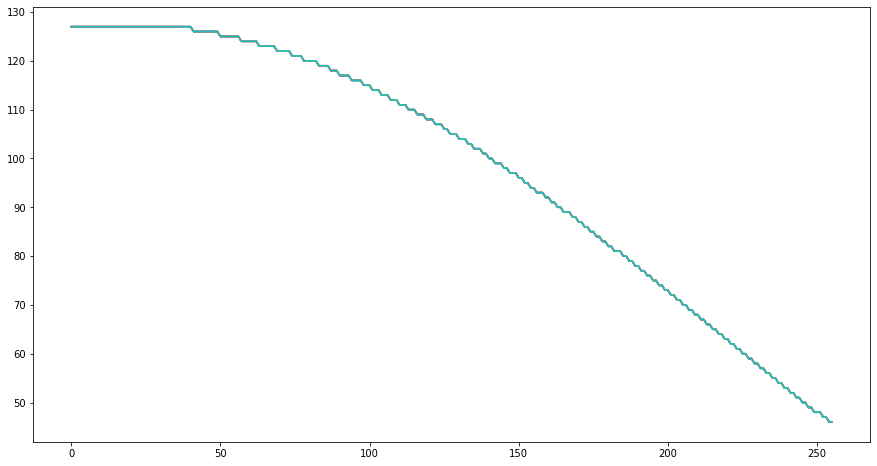

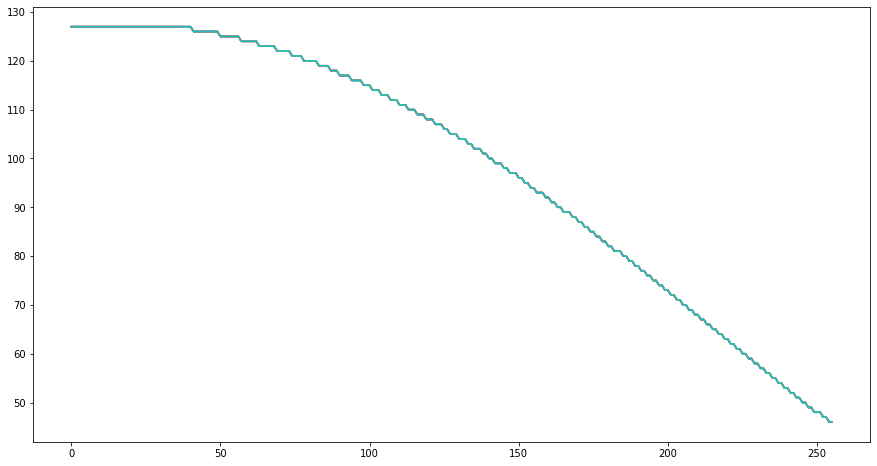

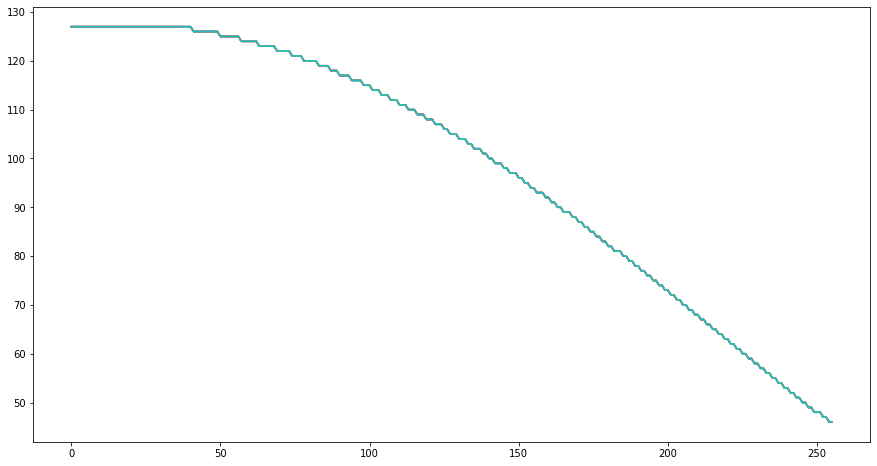

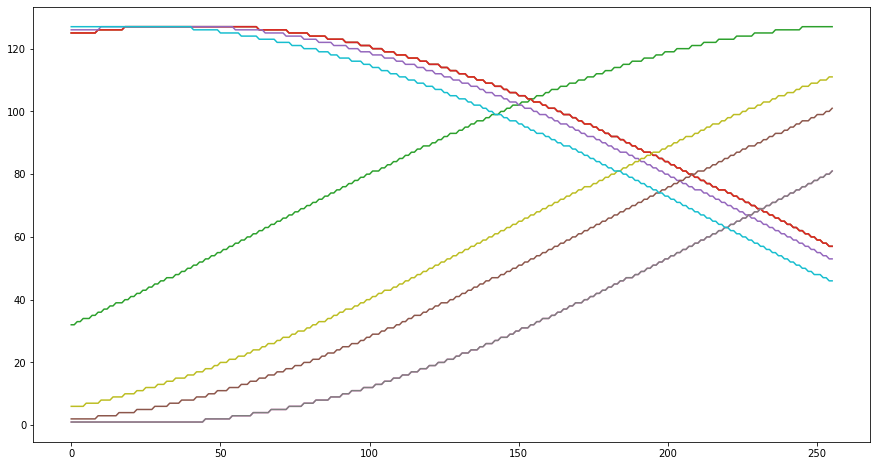

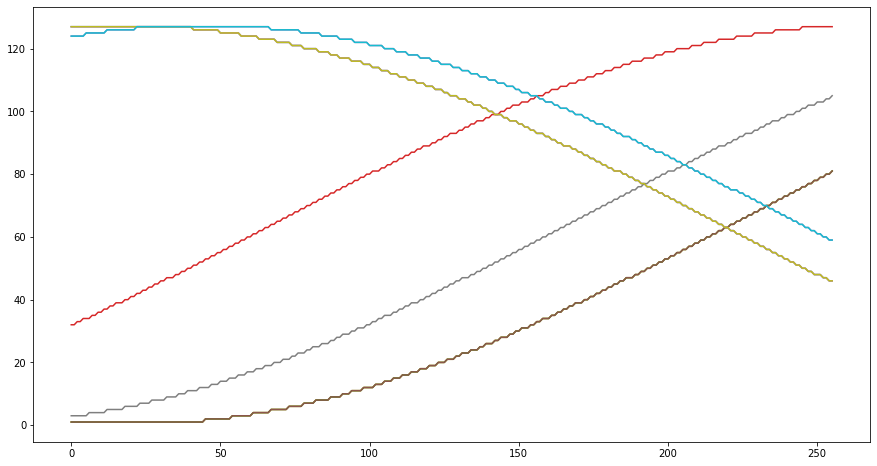

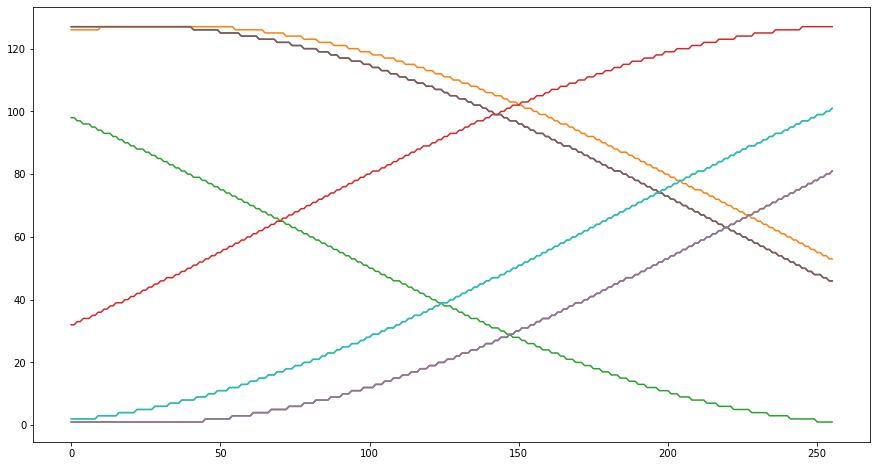

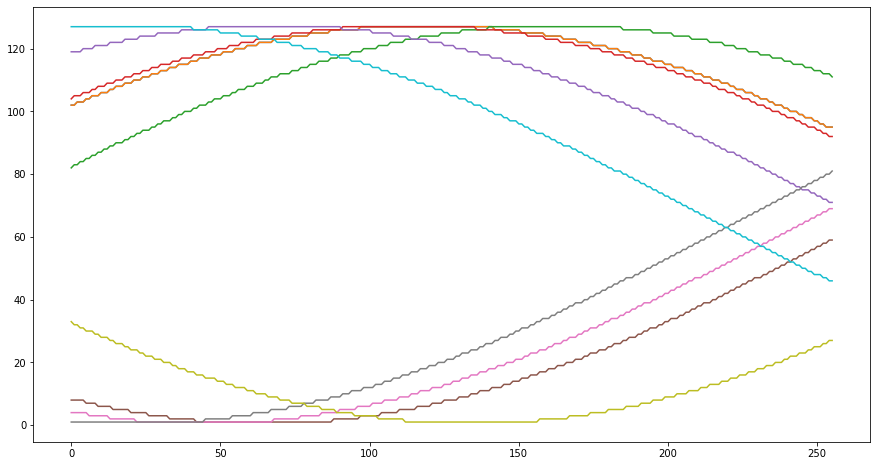

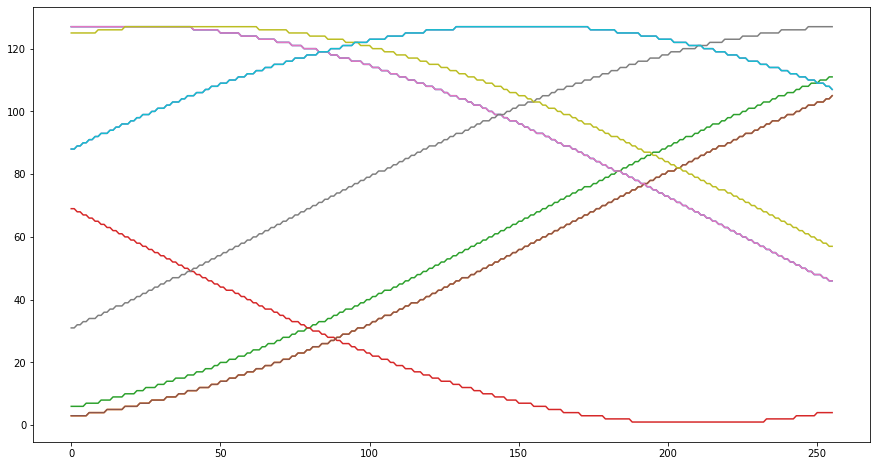

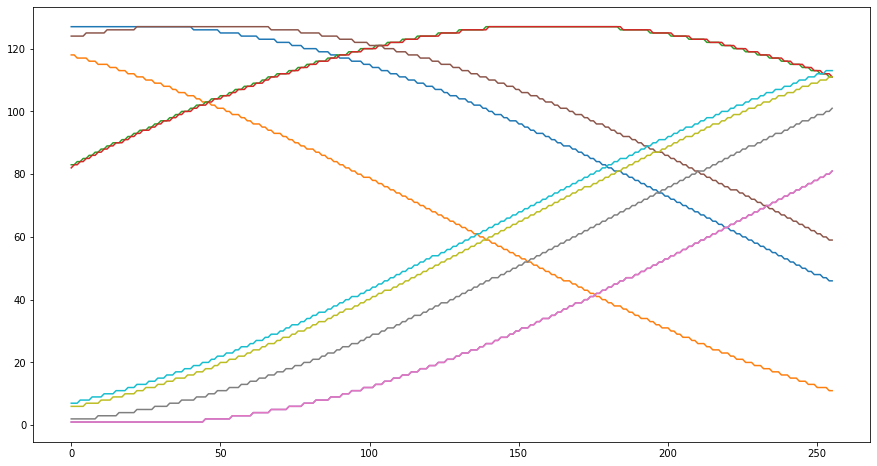

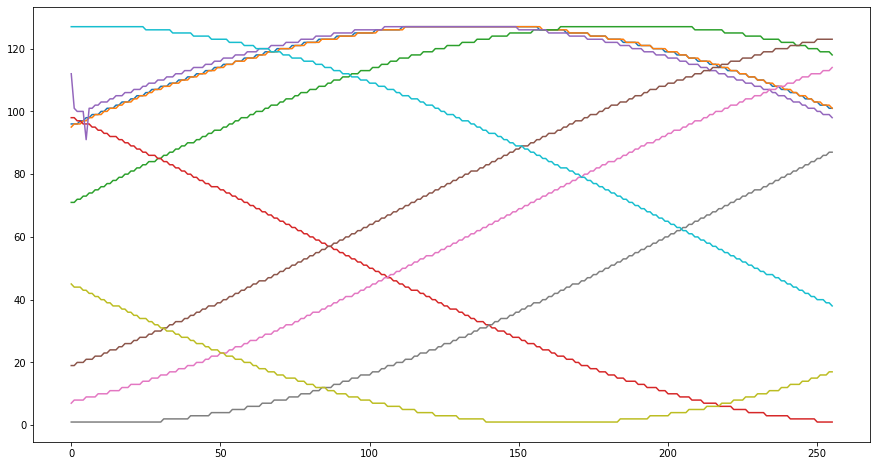

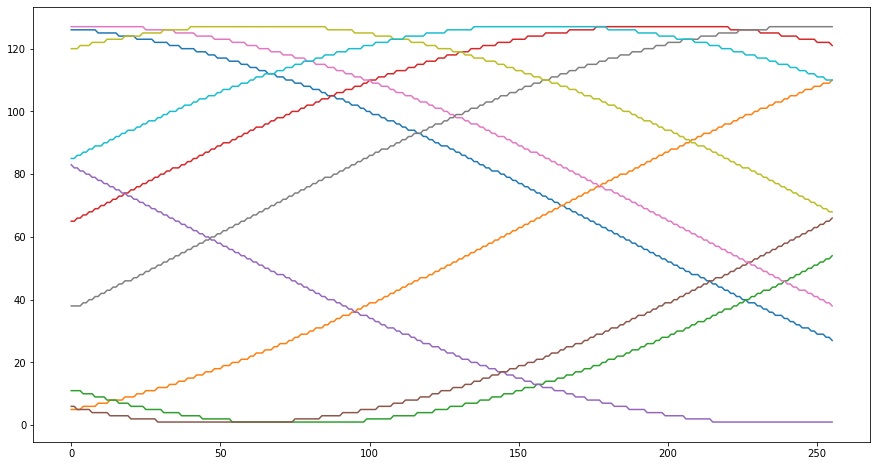

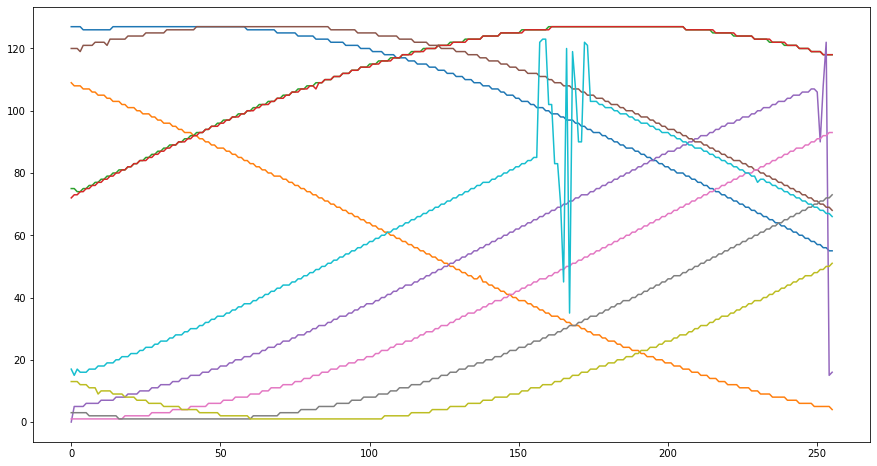

In [14]:
utils.seed(p_small)
t.train()
viz.plot_model_samples(m, ds.transforms, sample.simple, p_small)

## 🚨 Observations and Questions

- Why is this doing so much worse, given the only difference is 20 hz vz 440 hz?